# Training and validation images

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


DATA_DIRECTORY = '../../../Images'
BATCH_SIZE_FOR_IMAGES = 32
NUMBER_CLASSES = 0
CLASS_NAMES = []
SIZE = 224
IMAGE_SIZE = (SIZE, SIZE)

def get_data_for(name: str) -> ImageDataGenerator:
    return ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2).flow_from_directory(
        directory=DATA_DIRECTORY,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE_FOR_IMAGES,
        shuffle=True,
        subset=name,
    )


training = get_data_for("training")
validation = get_data_for("validation")

NUMBER_CLASSES = len(training.class_indices)
CLASS_NAMES = list(training.class_indices.keys())

print("Number of classes: ", NUMBER_CLASSES)
print("Class names: ", CLASS_NAMES)


2022-10-09 19:42:55.174944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 19:42:55.364937: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-09 19:42:56.239606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-09 19:42:56.239720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Number of classes:  12
Class names:  ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


## Show images

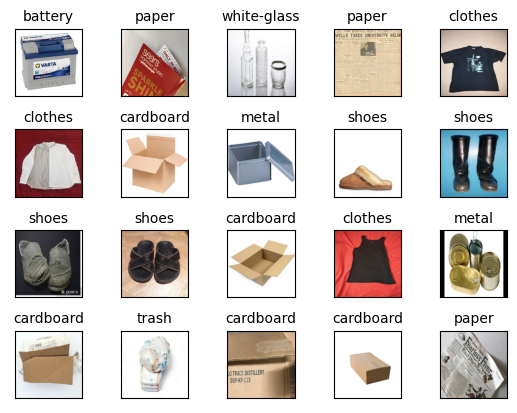

In [5]:
import matplotlib.pyplot as plt

TOTAL_IMAGES = 20

for imagen, label in training:
  for i in range(TOTAL_IMAGES):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i]/255) # Normalization
    plt.subplots_adjust(wspace=0.5, hspace=0.5)                              
    plt.title(CLASS_NAMES[label[i].argmax()], fontsize=10)         
  break 
plt.show()




# Neural Network Architecture

In [2]:
NEURAL_NETWORK = 'MNV3'

In [9]:

from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow import keras

IMAGE_SHAPE = (SIZE, SIZE, 3)

model_transfer_learning = MobileNetV3Large(
    input_shape=IMAGE_SHAPE, weights="imagenet", include_top=False
)
model_transfer_learning.trainable = False

IMAGE_INPUT = keras.Input(shape=IMAGE_SHAPE)
DROP_RATE=0.3
NUMBER_NEURONS=32

base = model_transfer_learning(IMAGE_INPUT, training=False)
pooling = keras.layers.GlobalAveragePooling2D()(base)
inner = keras.layers.Dense(NUMBER_NEURONS, activation='relu')(pooling)
dropout = keras.layers.Dropout(DROP_RATE)(inner)
output = keras.layers.Dense(NUMBER_CLASSES)(dropout)

model = keras.Model(IMAGE_INPUT, output)


2022-10-08 11:55:16.866040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Summary and plot model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                30752     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                396   

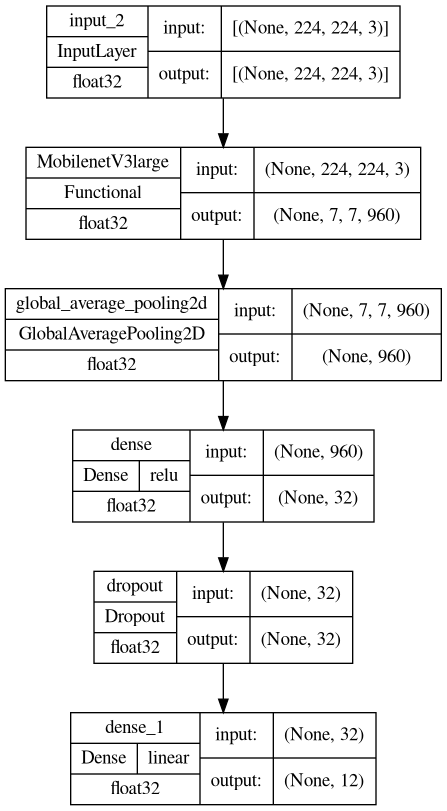

In [10]:
model.summary()
keras.utils.plot_model(
   model,
   to_file=f'{NEURAL_NETWORK}.png',
   show_shapes=True,
    show_dtype=True,
    show_layer_names=True,   
    dpi=96,
    show_layer_activations=True)

# Training parameters

In [3]:
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 32
TRAINING_NAME = f"{NEURAL_NETWORK}-{LEARNING_RATE}LR-{EPOCHS}E-{BATCH_SIZE}B"

## Compilation and Training

In [64]:
import time
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
start_time = time.time()
model.fit(
    training,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            f"Checkpoints/{NEURAL_NETWORK}"+"_{epoch:02d}_{val_accuracy:.3f}.h5",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
        ),
        keras.callbacks.TensorBoard(log_dir=f"logs/{TRAINING_NAME}"),
    ],
)
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/10
388/388 [==============================] - 319s 802ms/step - loss: 0.6272 - accuracy: 0.8063 - val_loss: 0.2338 - val_accuracy: 0.9245
Epoch 2/10
388/388 [==============================] - 320s 824ms/step - loss: 0.2412 - accuracy: 0.9256 - val_loss: 0.2016 - val_accuracy: 0.9290
Epoch 3/10
388/388 [==============================] - 330s 851ms/step - loss: 0.1894 - accuracy: 0.9399 - val_loss: 0.1782 - val_accuracy: 0.9358
Epoch 4/10
388/388 [==============================] - 339s 873ms/step - loss: 0.1498 - accuracy: 0.9540 - val_loss: 0.1729 - val_accuracy: 0.9358
Epoch 5/10
388/388 [==============================] - 349s 899ms/step - loss: 0.1279 - accuracy: 0.9591 - val_loss: 0.1667 - val_accuracy: 0.9445
Epoch 6/10
388/388 [==============================] - 357s 921ms/step - loss: 0.1127 - accuracy: 0.9643 - val_loss: 0.1524 - val_accuracy: 0.9471
Epoch 7/10
388/388 [==============================] - 344s 885ms/step - loss: 0.1023 - accuracy: 0.9650 - val_loss: 0.1739 -

## Evaluate model

In [5]:
loss, acc = model.evaluate(validation, verbose=1)
print(f'Accuracy: {(acc * 100.0):.3f}%\nLoss: {(loss*100):.3f}%')


97/97 [==============================] - 101s 1s/step - loss: 0.1650 - accuracy: 0.9513
Accuracy: 95.129%
Loss: 16.497%


## Confusion matrix

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix_for(model, data):
    cm = confusion_matrix(data.classes, np.argmax(model.predict(data), axis=1))    
    df_cm = pd.DataFrame(cm, index=data.class_indices.keys(), columns=data.class_indices.keys())
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="GnBu")
    plt.title("Validation")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

97/97 [==============================] - 94s 961ms/step


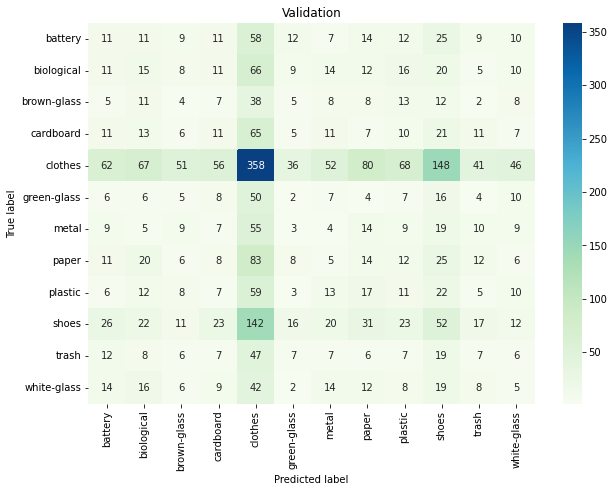

In [7]:
plot_confusion_matrix_for(model, validation)

## Save model

In [ ]:
model.save(f"{TRAINING_NAME}-MODEL.h5")

## Load model

In [10]:
import tensorflow.keras as keras
model = keras.models.load_model(f"{TRAINING_NAME}-MODEL.h5")
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_8   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 32)                30752     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 12)                396 

# Fine tuning taken from [keras](https://keras.io/guides/transfer_learning/)

In [8]:
NEURAL_NETWORK = 'MNV3-FT'

In [9]:
LEARNING_RATE = 1e-5
EPOCHS = 10
BATCH_SIZE = 32
TRAINING_NAME = f"{NEURAL_NETWORK}-{LEARNING_RATE}LR-{EPOCHS}E-{BATCH_SIZE}B"

In [16]:
model.summary()
keras.utils.plot_model(
   model,
   to_file=f'{NEURAL_NETWORK}.png',
   show_shapes=True,
    show_dtype=True,
    show_layer_names=True,   
    dpi=96,
    show_layer_activations=True)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_8   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 32)                30752     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 12)                396 

In [17]:
import time
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
start_time = time.time()
model.fit(
    training,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            f"Checkpoints/{NEURAL_NETWORK}"+"_{epoch:02d}_{val_accuracy:.3f}.h5",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
        ),
        keras.callbacks.TensorBoard(log_dir=f"../Logs/{TRAINING_NAME}"),
    ],
)
print(f"--- {(time.time() - start_time):2f} seconds ---")

Epoch 1/10
388/388 [==============================] - 518s 1s/step - loss: 0.0624 - accuracy: 0.9778 - val_loss: 0.1680 - val_accuracy: 0.9481
Epoch 2/10
388/388 [==============================] - 472s 1s/step - loss: 0.0461 - accuracy: 0.9849 - val_loss: 0.1640 - val_accuracy: 0.9516
Epoch 3/10
388/388 [==============================] - 456s 1s/step - loss: 0.0391 - accuracy: 0.9878 - val_loss: 0.1593 - val_accuracy: 0.9561
Epoch 4/10
388/388 [==============================] - 442s 1s/step - loss: 0.0368 - accuracy: 0.9864 - val_loss: 0.1672 - val_accuracy: 0.9535
Epoch 5/10
388/388 [==============================] - 452s 1s/step - loss: 0.0310 - accuracy: 0.9896 - val_loss: 0.1642 - val_accuracy: 0.9561
Epoch 6/10
388/388 [==============================] - 451s 1s/step - loss: 0.0

## Evaluate the model

In [22]:
loss, acc = model.evaluate(validation, verbose=1)
print(f'Accuracy: {(acc * 100.0):.3f}%\nLoss: {(loss*100):.3f}%')

97/97 [==============================] - 87s 908ms/step - loss: 0.1790 - accuracy: 0.9568
Accuracy: 95.677%
Loss: 17.902%


## Matrix confusion

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix_for(model, data):
    cm = confusion_matrix(data.classes, np.argmax(model.predict(data), axis=1))    
    df_cm = pd.DataFrame(cm, index=data.class_indices.keys(), columns=data.class_indices.keys())
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="GnBu")
    plt.title("Validation")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

97/97 [==============================] - 103s 1s/step


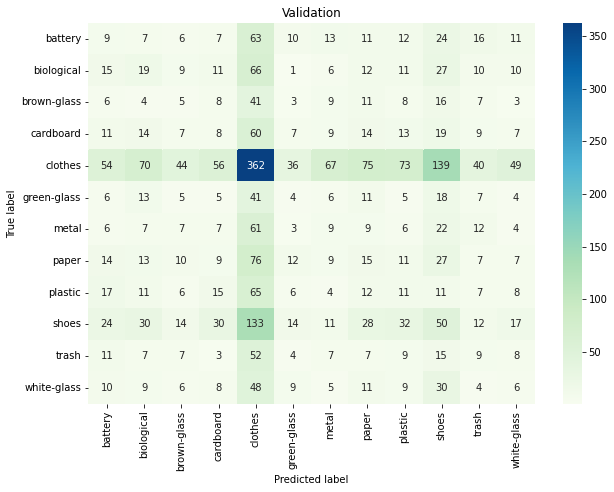

In [11]:
plot_confusion_matrix_for(model, validation)

# Predictions

## Without fine tuning

1/1 [==============================] - 1s 1s/step


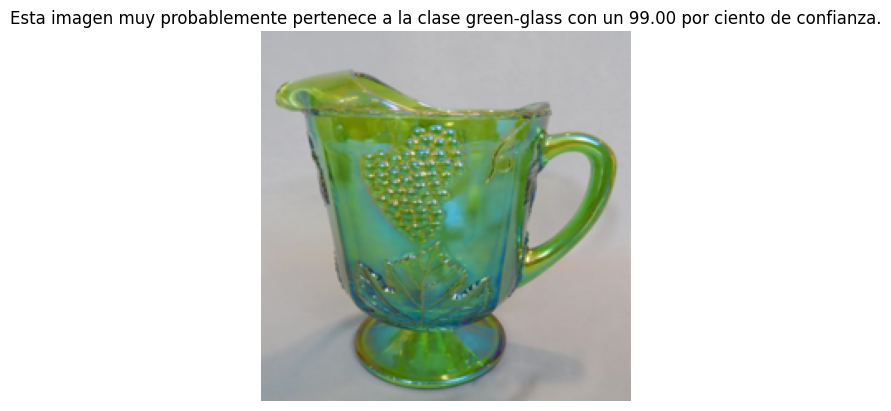

In [13]:
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
# IMAGE_URL = "https://i.imgur.com/r9x5iai.png"
# IMAGE_URL = "https://i.imgur.com/UQwyQJU.png"
# IMAGE_URL = "https://i.imgur.com/jvtZ8Ku.png"
# IMAGE_URL = "https://i.imgur.com/c6Dltoq.png"
# IMAGE_URL = "https://i.imgur.com/sHB61UV.png"
# IMAGE_URL = "https://i.imgur.com/2p6B0O4.png"
# IMAGE_URL = "https://i.imgur.com/JXVJ5YA.png"
# IMAGE_URL = "https://i.imgur.com/DxW39ii.png"
IMAGE_URL = "https://i.imgur.com/nYz7jll.png"
image = Image.open(BytesIO(requests.get(IMAGE_URL).content)).resize((SIZE, SIZE))
prediction = model.predict(preprocess_input(np.expand_dims(np.array(image), axis=0)))
score = tf.nn.softmax(prediction)

plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
plt.axis('off')
plt.imshow(np.array(image))


1/1 [==============================] - 0s 95ms/step


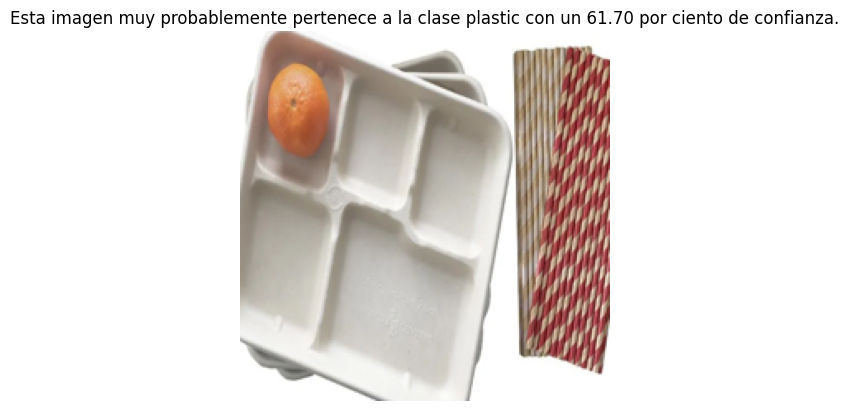

1/1 [==============================] - 0s 46ms/step


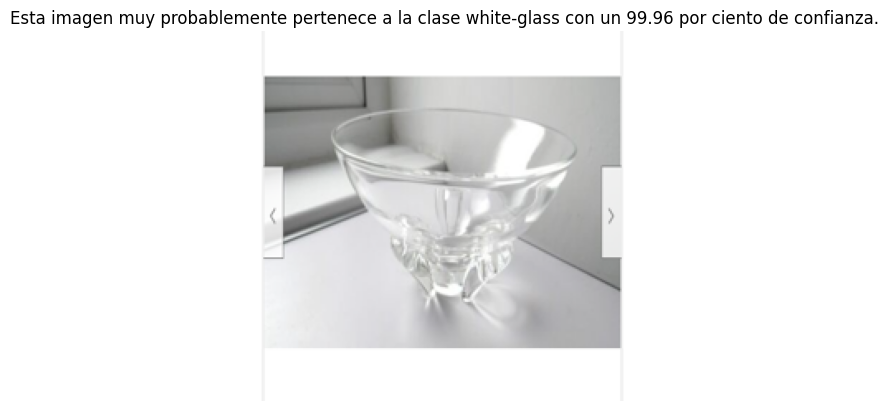

1/1 [==============================] - 0s 45ms/step


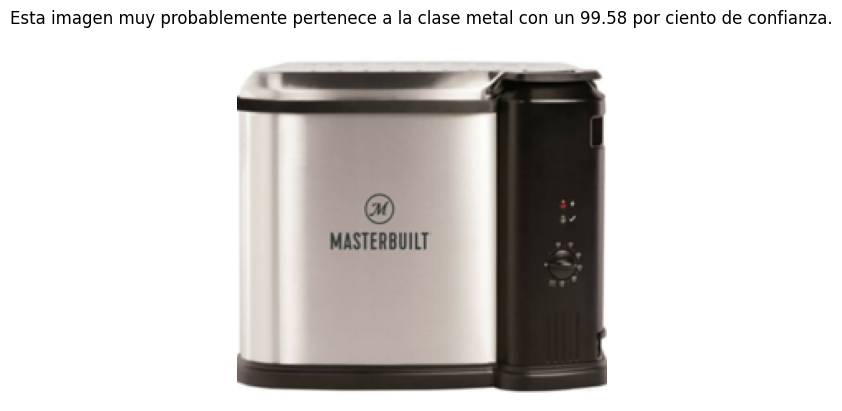

1/1 [==============================] - 0s 83ms/step


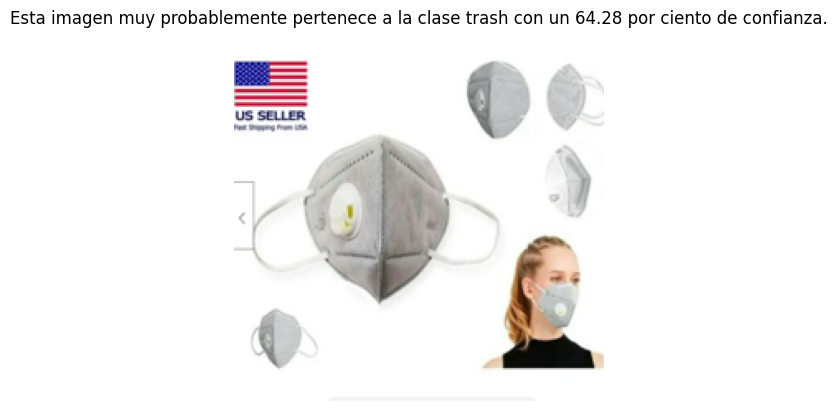

1/1 [==============================] - 0s 60ms/step


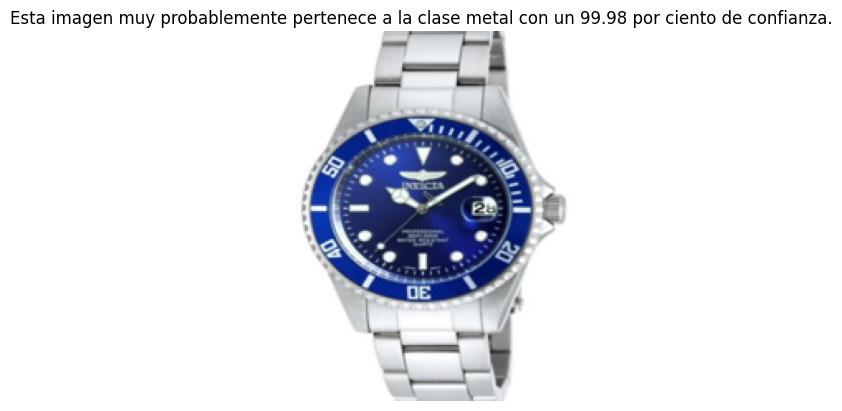

1/1 [==============================] - 0s 46ms/step


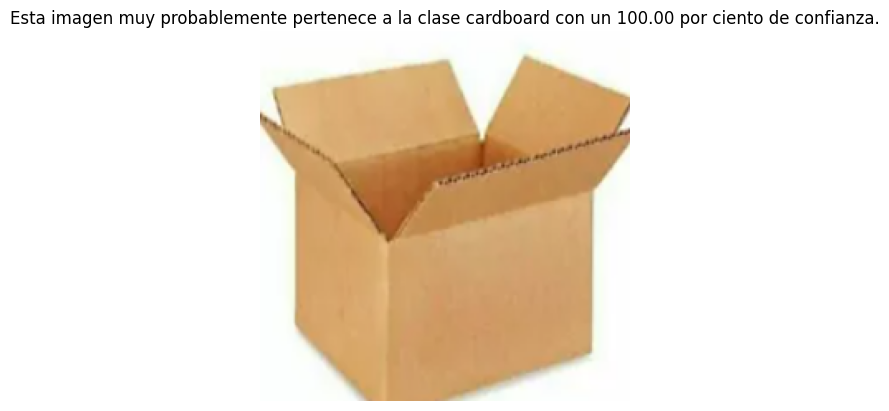

1/1 [==============================] - 0s 53ms/step


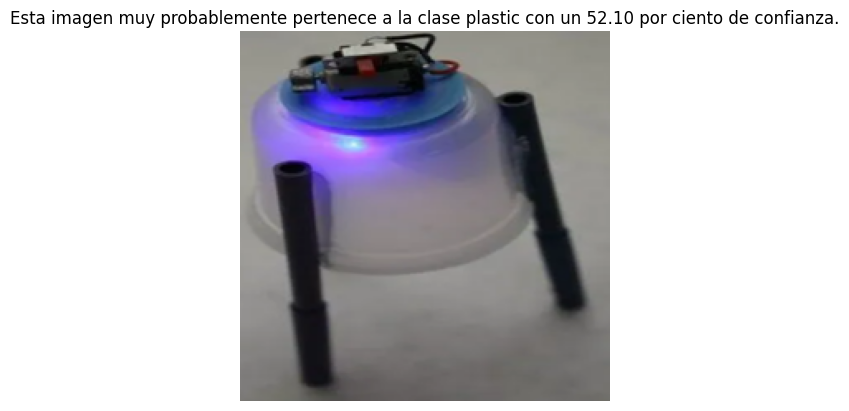

1/1 [==============================] - 0s 49ms/step


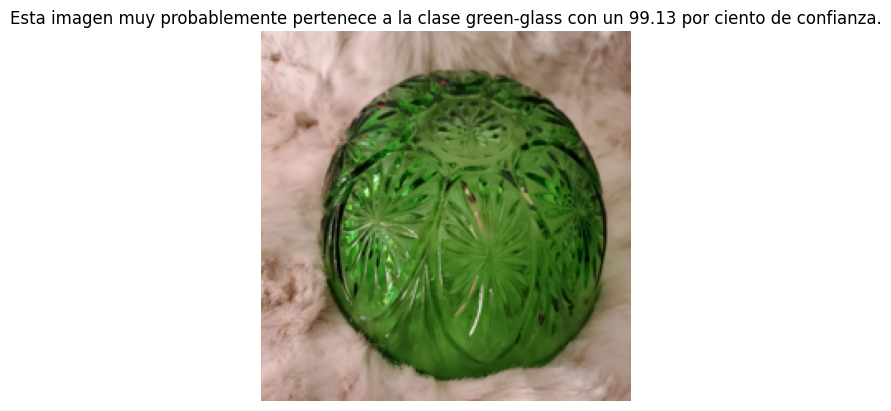

1/1 [==============================] - 0s 45ms/step


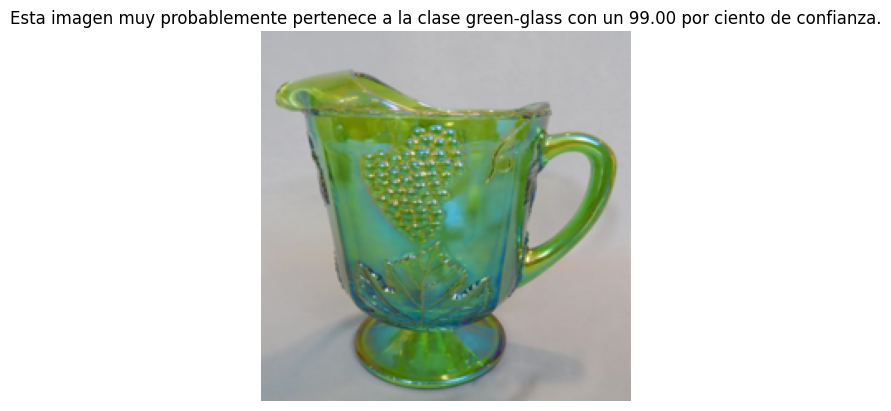

In [14]:
images_url = [ "https://i.imgur.com/r9x5iai.png", "https://i.imgur.com/UQwyQJU.png", "https://i.imgur.com/jvtZ8Ku.png", "https://i.imgur.com/c6Dltoq.png", "https://i.imgur.com/sHB61UV.png", "https://i.imgur.com/2p6B0O4.png", "https://i.imgur.com/JXVJ5YA.png", "https://i.imgur.com/DxW39ii.png", "https://i.imgur.com/nYz7jll.png"]

for image_url in images_url:
  image = Image.open(BytesIO(requests.get(image_url).content)).resize((SIZE, SIZE))  
  prediction = model.predict(preprocess_input(np.expand_dims(image, axis=0)))
  score = tf.nn.softmax(prediction)
  plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
  plt.axis('off')  
  plt.imshow(np.array(image.resize(IMAGE_SIZE)))
  plt.show()

## With fine tuning

1/1 [==============================] - 1s 888ms/step


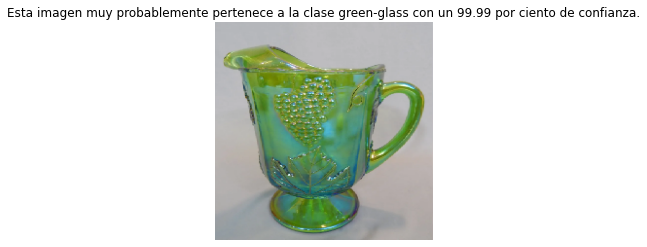

In [12]:
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
# IMAGE_URL = "https://i.imgur.com/r9x5iai.png"
# IMAGE_URL = "https://i.imgur.com/UQwyQJU.png"
# IMAGE_URL = "https://i.imgur.com/jvtZ8Ku.png"
# IMAGE_URL = "https://i.imgur.com/c6Dltoq.png"
# IMAGE_URL = "https://i.imgur.com/sHB61UV.png"
# IMAGE_URL = "https://i.imgur.com/2p6B0O4.png"
# IMAGE_URL = "https://i.imgur.com/JXVJ5YA.png"
# IMAGE_URL = "https://i.imgur.com/DxW39ii.png"
IMAGE_URL = "https://i.imgur.com/nYz7jll.png"
image = Image.open(BytesIO(requests.get(IMAGE_URL).content)).resize((SIZE, SIZE))
prediction = model.predict(preprocess_input(np.expand_dims(np.array(image), axis=0)))
score = tf.nn.softmax(prediction)

plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
plt.axis('off')
plt.imshow(np.array(image))


1/1 [==============================] - 0s 39ms/step


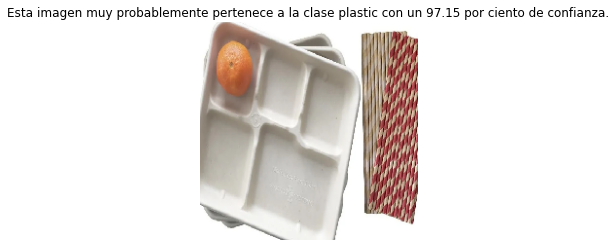

1/1 [==============================] - 0s 37ms/step


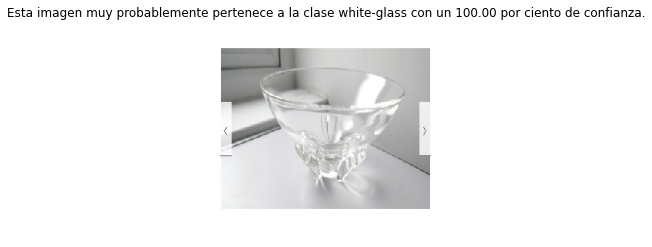

1/1 [==============================] - 0s 37ms/step


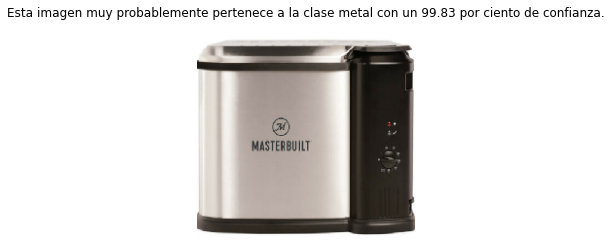

1/1 [==============================] - 0s 37ms/step


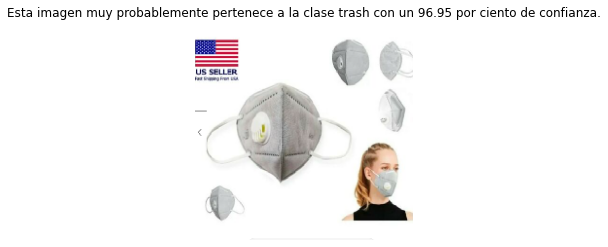

1/1 [==============================] - 0s 36ms/step


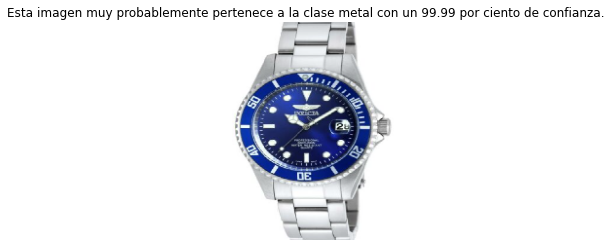

1/1 [==============================] - 0s 36ms/step


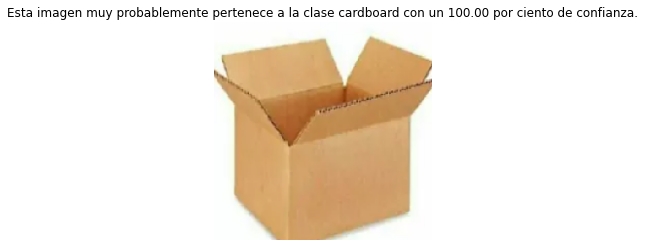

1/1 [==============================] - 0s 41ms/step


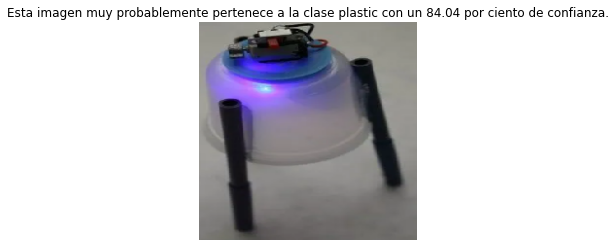

1/1 [==============================] - 0s 73ms/step


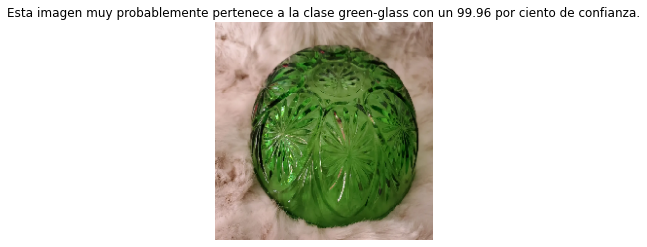

1/1 [==============================] - 0s 41ms/step


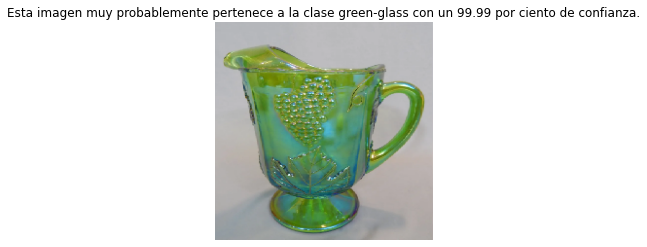

In [13]:
images_url = [ "https://i.imgur.com/r9x5iai.png", "https://i.imgur.com/UQwyQJU.png", "https://i.imgur.com/jvtZ8Ku.png", "https://i.imgur.com/c6Dltoq.png", "https://i.imgur.com/sHB61UV.png", "https://i.imgur.com/2p6B0O4.png", "https://i.imgur.com/JXVJ5YA.png", "https://i.imgur.com/DxW39ii.png", "https://i.imgur.com/nYz7jll.png"]

for image_url in images_url:
  image = Image.open(BytesIO(requests.get(image_url).content)).resize((SIZE, SIZE))  
  prediction = model.predict(preprocess_input(np.expand_dims(image, axis=0)))
  score = tf.nn.softmax(prediction)
  plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
  plt.axis('off')  
  plt.imshow(np.array(image.resize(IMAGE_SIZE)))
  plt.show()